In [6]:
import pandas as pd

total_interpro_df = pd.read_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t')

#add columns to raw data
# new_column_names = [
#     'Protein accession',
#     'Sequence MD5 digest',
#     'Sequence length',
#     'Analysis',
#     'Signature accession',
#     'Signature description',
#     'Start location',
#     'Stop location',
#     'Score',
#     'Status',
#     'Date',
#     'InterPro annotations - accession',
#     'InterPro annotations - description',
#     'GO annotations',
#     'Pathways annotations'
# ]
#total_interpro_df.columns = new_column_names # add columns to raw data

#total_interpro_df.to_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t',index=False,header=True) # save to file

# ESM-2 Embedding with UMAP

## Extract embedding 

In [9]:
import sys
import os
os.chdir('/mnt/yizhou/Shenzhen_GLM_Project/Core')

from Utils.utils import *

#load esm embedding and labels
esm_embedding, esm_embedding_accession = load_esm_embedding('/mnt/yizhou/Data/Preparation_Data/total_esm2_embedding.pkl')

## Find top 10 pfam from Interpro scan

In [13]:
import pandas as pd
interpro_result = pd.read_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t')
#sort by protein accession
interpro_result = interpro_result.sort_values(by='Protein accession')


In [12]:
import numpy as np
def get_top_pfam_labels(interpro_result,top=10):
    """
    args:
        interpro_result: interpro result dataframe
        top: top n most frequent labels of pfam
    """

    #filter labels from pfam database
    pfam_labels = interpro_result[interpro_result['Analysis']=='Pfam']
    # top 10 most frequent labels
    top_labels = pfam_labels['Signature description'].value_counts().index[:top]
    # filter data with top 10 labels
    top_labels_data = pfam_labels[pfam_labels['Signature description'].isin(top_labels)].reset_index(drop=True)

    return top_labels_data 

def get_non_duplicated_top_pfam_labels(top_pfam_labels):
    #remove duplicated protein accessions
    top_pfam_labels = top_pfam_labels.drop_duplicates(subset=['Protein accession'])
    return top_pfam_labels


def get_non_duplicated_pfam_labels(interpro_result):
    # Keep rows where the Analysis column is 'Pfam'
    pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam']
    
    # Find protein accessions that do not have Pfam annotations
    non_pfam_proteins = interpro_result[~interpro_result['Protein accession'].isin(pfam_labels['Protein accession'])]
    
    # From non_pfam_proteins, keep the first occurrence of each protein accession
    non_pfam_unique = non_pfam_proteins.drop_duplicates(subset=['Protein accession'], keep='first')
    
    # Combine Pfam annotations with unique non-Pfam annotations, ensuring no duplicates in the final result
    combined_result = pd.concat([pfam_labels, non_pfam_unique]).drop_duplicates(subset=['Protein accession'], keep='first')
    
    return combined_result

def get_top_pfam_labels_embedding(top_pfam_labels,esm_embedding,esm_embedding_accession):
    """
    args:
        top_pfam_labels: non duplicated top pfam labels
        esm_embedding: esm embedding : list
        esm_embedding_accession: esm embedding accession : list
    """
    #get top pfam labels embedding
    esm_embedding_array = np.array(esm_embedding)
    esm_embedding_accession_array = np.array(esm_embedding_accession)
    #sort all the raw sequences and top sequences first!
    sort_indices = np.argsort(esm_embedding_accession_array)
    esm_embedding_array = esm_embedding_array[sort_indices]
    esm_embedding_accession_array = esm_embedding_accession_array[sort_indices]
    #sort target sequences and their corresponding labels!
    target_sequences_array = np.array(top_pfam_labels['Protein accession'].values)
    target_sequences_label_array = np.array(top_pfam_labels['Signature description'].values)
    sort_indices = np.argsort(target_sequences_array)
    target_sequences_array = target_sequences_array[sort_indices]
    target_sequences_label_array = target_sequences_label_array[sort_indices]
    #get target sequences from raw sequences
    target_mask = np.isin(esm_embedding_accession_array,target_sequences_array)
    target_esm_embedding_array = esm_embedding_array[target_mask]

    return target_esm_embedding_array,target_sequences_label_array,target_mask,target_sequences_array
    




## extract embeddings from those pfam labels

In [15]:
top_labels_data = get_top_pfam_labels(interpro_result,top=10)
top_labels_data = get_non_duplicated_top_pfam_labels(top_labels_data)
top_labels_embedding,top_labels,top_mask,top_sequences = get_top_pfam_labels_embedding(top_labels_data,esm_embedding,esm_embedding_accession)


In [16]:
esm_embedding_accession_df = pd.DataFrame(esm_embedding_accession,columns=['Protein accession'])
esm_embedding_accession_df.sort_values(by='Protein accession',inplace=True) #sort by protein accession

pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam'].reset_index(drop=True) #all pfam annonated labels

#get if top_10 labels
esm_embedding_accession_df['if_is_top10_pfam'] = top_mask.astype(bool)


#merge all sequences with pfam labels
esm_embedding_accession_df = pd.merge(esm_embedding_accession_df,pfam_labels[['Protein accession','Signature description']],on='Protein accession',how='left')
esm_embedding_accession_df['Signature description'] = esm_embedding_accession_df['Signature description'].apply(lambda x: x if x in top_labels else 'No Pfam') #replace non top 10 labels or Nan with 'No Pfam'


In [28]:
from tqdm import tqdm
def deduplicate_group(group):
    # Check if there are any non 'No Pfam' labels
    non_no_pfam = group[group['Signature description'] != 'No Pfam']
    if not non_no_pfam.empty:
        # If there are non 'No Pfam' labels, keep one of them
        return non_no_pfam.iloc[:1] # return dataframe :()
    else:
        # Otherwise, keep one of the rows with 'No Pfam'
        return group.iloc[:1]

# Apply deduplication function to each group with progress bar
grouped = esm_embedding_accession_df.groupby('Protein accession')

# Use tqdm to show progress
deduplicated_df_list = []
for name, group in tqdm(grouped, total=len(grouped)):
    deduplicated_df_list.append(deduplicate_group(group))

deduplicated_df = pd.concat(deduplicated_df_list, ignore_index=True)

100%|██████████| 128012/128012 [00:54<00:00, 2328.12it/s]


## UMAP reduce and cluster

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

umap_config_euc = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'euclidean',
    'min_dist':0.5,
    'local_connectivity':1,
}

umap_config_cos = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'cosine',
    'min_dist':0.5,
    'local_connectivity':1,
}

#get sorted esm_embedding array.
esm_embedding_accession_array = np.array(esm_embedding_accession)
sort_indices = np.argsort(esm_embedding_accession_array)
esm_embedding_array = np.array(esm_embedding)[sort_indices]


#get cosine and euclidean reduce embeddings
umap_reducer_euc = umap.UMAP(**umap_config_euc)
umap_embedding_euc = umap_reducer_euc.fit_transform(esm_embedding_array)

umap_reducer_cos = umap.UMAP(**umap_config_cos)
umap_embedding_cos = umap_reducer_cos.fit_transform(esm_embedding_array)


In [32]:

#get umap_df
umap_df_euc = pd.DataFrame(umap_embedding_euc,columns=['x','y'])
umap_df_cos = pd.DataFrame(umap_embedding_cos,columns=['x','y'])
umap_df_euc['type'] = deduplicated_df['Signature description']
umap_df_cos['type'] = deduplicated_df['Signature description']

umap_df_euc['id'] = deduplicated_df.index
umap_df_cos['id'] = deduplicated_df.index


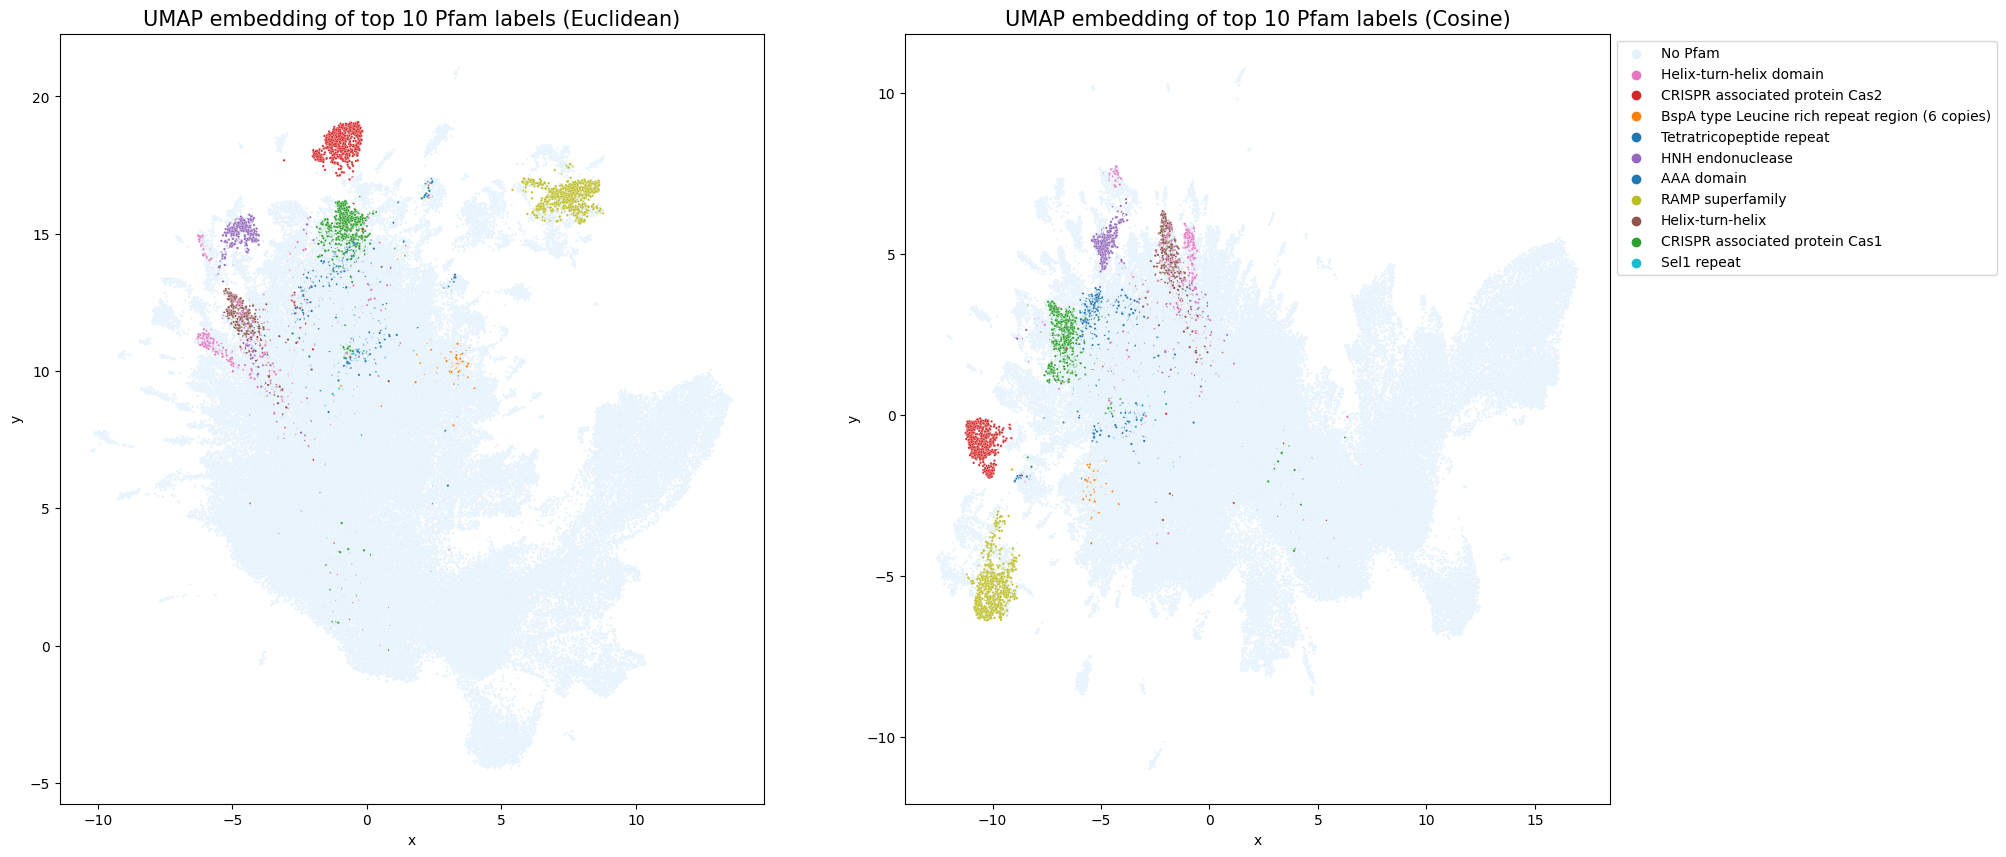

In [58]:
#before drawing set parameters
labels = umap_df_euc['type'] #type is label
unique_labels = np.unique(labels)

# 生成基础调色板
base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))

# 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: ('#E3F2FD' if label == 'No Pfam' else base_palette[i]) for i, label in enumerate(unique_labels)}
# 将图例放置到右上角，且不介入图中
# 绘制散点图，使用更新的调色板
# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 绘制EUC的UMAP散点图
sns.scatterplot(x=umap_df_euc.x, y=umap_df_euc.y, hue=labels, palette=palette, s=3, ax=axes[0])
axes[0].set_title("UMAP embedding of top 10 Pfam labels (Euclidean)", fontsize=15)

# 生成COS数据的标签
labels_cos = umap_df_cos['type']

# 绘制COS的UMAP散点图
sns.scatterplot(x=umap_df_cos.x, y=umap_df_cos.y, hue=labels, palette=palette, s=3, ax=axes[1])
axes[1].set_title("UMAP embedding of top 10 Pfam labels (Cosine)", fontsize=15)

#去掉legend
axes[0].get_legend().remove()
axes[1].get_legend().remove()
#最右边画legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


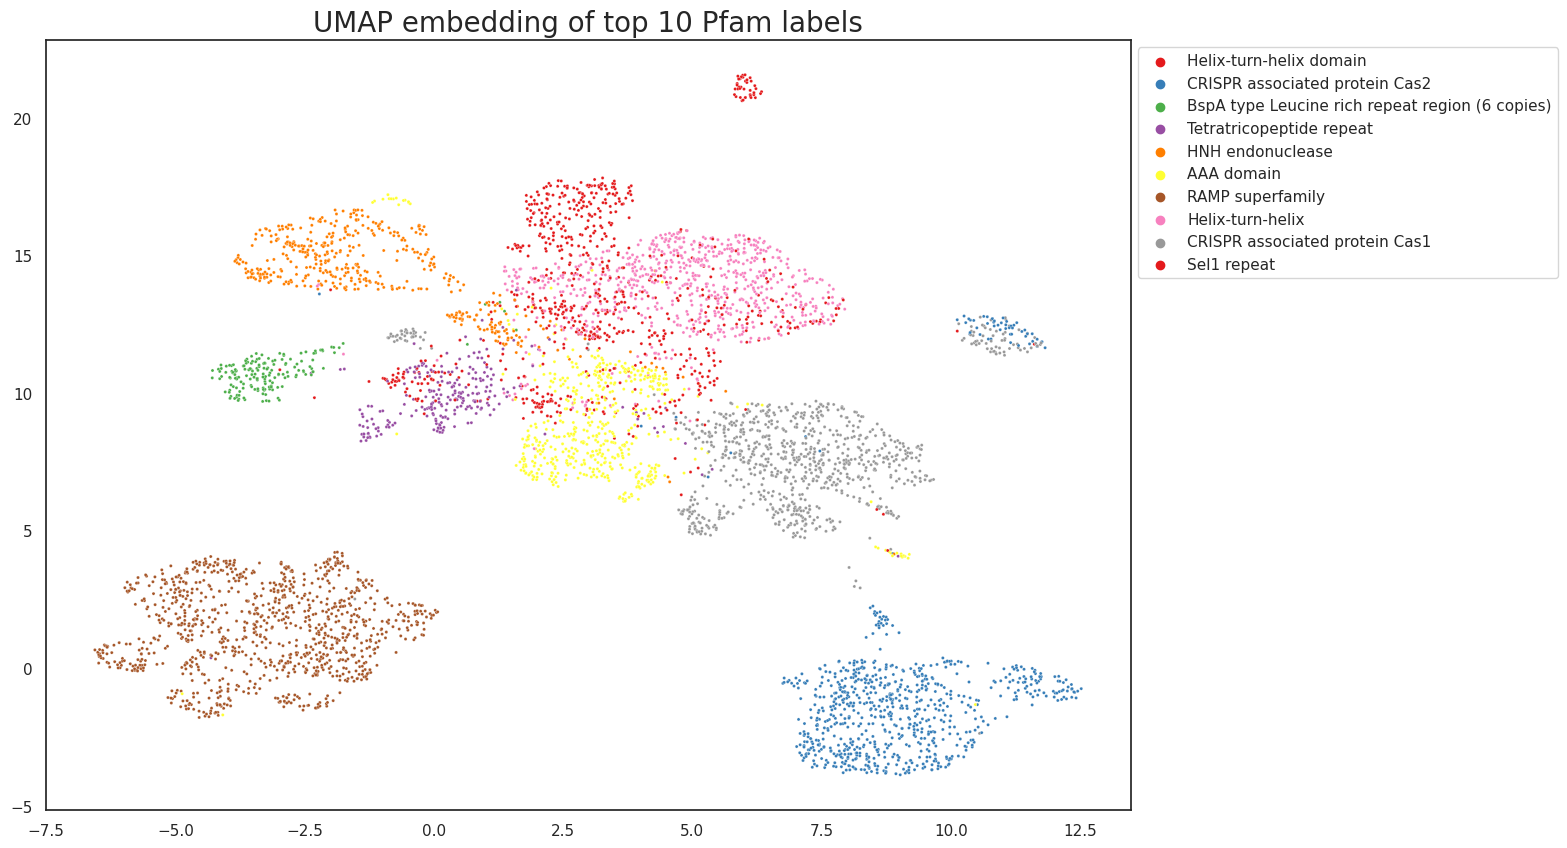

In [372]:
#get umap df,x_1 embedding,x_2 embedding,label (top 10 pfam)
umap_df = pd.DataFrame(umap_data,columns=['x','y'])
umap_df['type'] = deduplicated_df.loc[:,'Signature description'].values
umap_df.loc[:,'type'].value_counts().head(15)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = umap_df['type']
unique_labels = np.unique(labels)

# 生成基础调色板
base_palette = sns.color_palette("Set1", n_colors=len(unique_labels))

# 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: ('white' if label == 'No Pfam' else base_palette[i]) for i, label in enumerate(unique_labels)}
# 将图例放置到右上角，且不介入图中
# 绘制散点图，使用更新的调色板
scatter = sns.scatterplot(x=umap_df.x, y=umap_df.y, 
                          hue=labels, palette=palette, s=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("UMAP embedding of top 10 Pfam labels",fontsize=20)

plt.show()